# Lines and asemic writing with vsketch

By [Allison Parrish](http://www.decontextualize.com/)

This notebook is a tutorial on producing asemic glyphs in a computational fashion. It also has some simple techniques for laying those glyphs out on the page. The material here is especially suitable for producing computational asemic glyphs for plotter pen devices.

We'll be using two libraries: [vsketch](https://vsketch.readthedocs.io/en/latest/index.html) for drawing and exporting to SVG, and [bezmerizing](https://github.com/aparrish/bezmerizing/) for Bézier curve math and some other niceties. Install those libraries according to the instructions on their respective pages, or by running the cells below:

In [ ]:
import sys
!{sys.executable} -m pip install git+https://github.com/abey79/vsketch

In [ ]:
import sys
!{sys.executable} -m pip install --upgrade https://github.com/aparrish/bezmerizing/archive/master.zip

And then import the code like so:

In [19]:
import random
import vsketch
import bezmerizing

We'll also need some supporting functions from [numpy](https://numpy.org/):

In [7]:
from numpy.random import uniform, normal, choice
import numpy as np

In [5]:
from scipy.stats import truncnorm
def t_normal(a, b, mu, sigma):
    tn = truncnorm((a-mu)/sigma, (b-mu)/sigma, loc=mu, scale=sigma)
    return tn.rvs(1)[0]

## Preliminaries, part 1: Drawing with vsketch

The [vsketch Python library](https://vsketch.readthedocs.io/en/latest/index.html) provides an API to the powerful plotter-centric drawing tools of [vpype](https://github.com/abey79/vpype/). The API is easy to learn and has a number of features that make it specifically suitable for plotter outputs. It does have some shortcomings (which we'll discuss), and it's not a general-purpose library for drawing vector graphics. But for our purposes, it will work out great.

In this section, I show how to use vsketch to draw basic shapes.

### I've got a blank page, baby

The example below shows the most basic steps for setting up and displaying a vsketch drawing. First, I instantiate a `Vsketch` object, then set its size with the `.size()` method, and then `.display()` it (which causes the drawing to appear in the output section of the notebook cell).

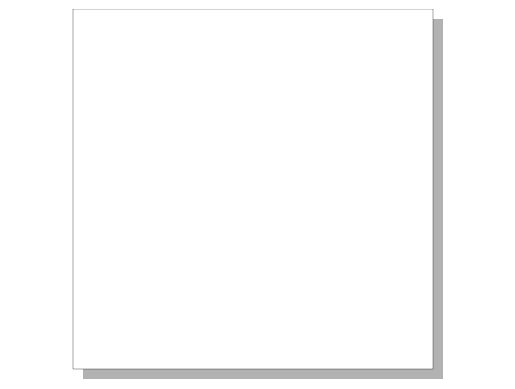

In [9]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.display()

The parameters of the `.size()` method set the size of the page. In the example above, I've set the size of the page using `mm` units, but the function also takes `cm` (centimeters), `in` (inches), and `px` (CSS pixels). You can also provide a single parameter to `.size()` with the name of the size of paper, picking from the following options:

    a6, a5, a4, a3, a2, a1, a0, letter, legal, executive, tabloid
    
Preset paper sizes default to portrait orientation; you can change this with the `landscape=True` parameter. A few more examples:

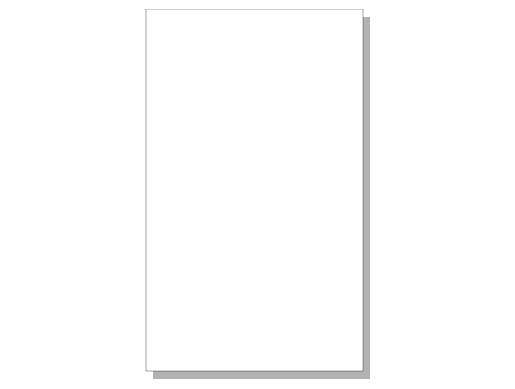

In [14]:
# index card size
vsk = vsketch.Vsketch()
vsk.size("3in", "5in")
vsk.display()

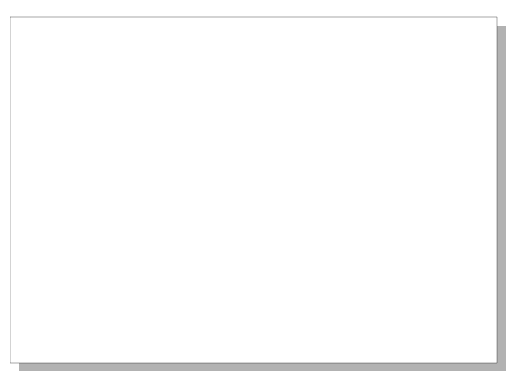

In [13]:
# landscape a6
vsk = vsketch.Vsketch()
vsk.size("a6", landscape=True)
vsk.display()

By default, the `.display()` method resizes the in-notebook display to a reasonable size. You can override this with the `fig_size` parameter, which expects a tuple specifying the width and height of the preview in inches. This canvas is actually 1"$\times$1", but the preview shows it as 10"$\times$10":

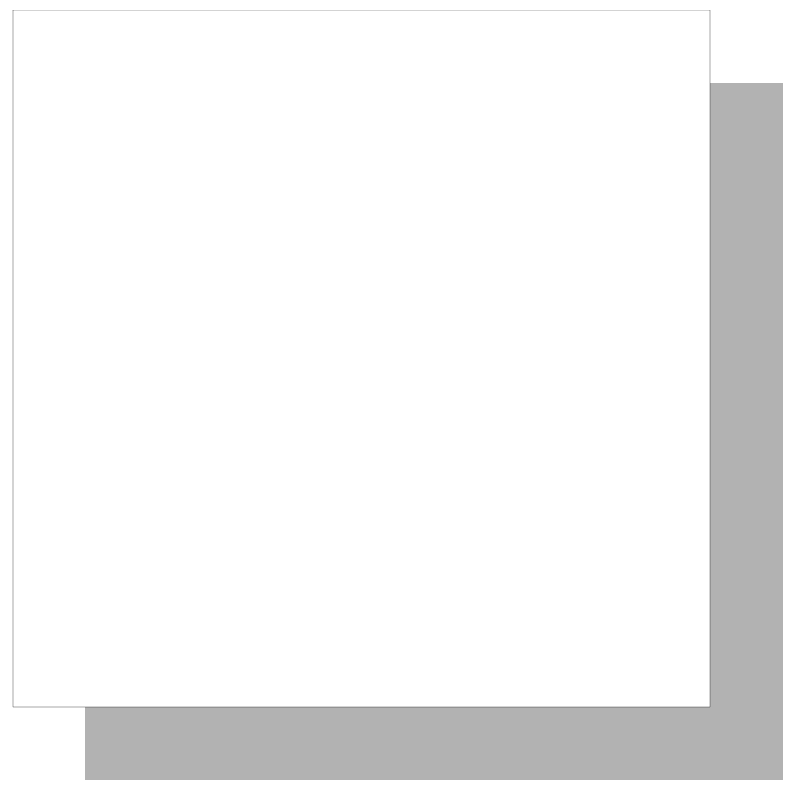

In [271]:
vsk = vsketch.Vsketch()
vsk.size("1in", "1in")
vsk.display(fig_size=(10, 10))

### Shapes, units, coordinates

To draw a shape on the sketch, call one of the `Vsketch` object's shape methods. You can find a list of these [in the documentation](https://vsketch.readthedocs.io/en/latest/autoapi/vsketch/index.html#vsketch.Vsketch). In this tutorial, I only use `.circle()`, `.rect()`, `.line()` and `.polygon()`, but you're welcome to explore the others on your own. Here's how to draw a circle with radius 45:

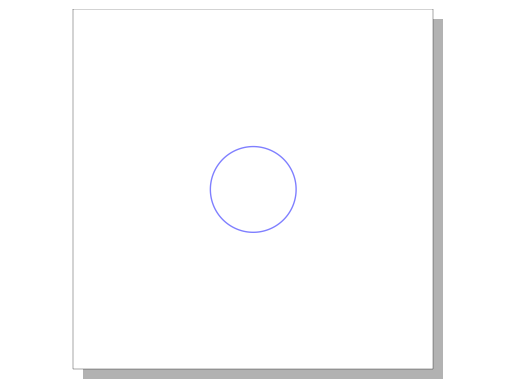

In [15]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.circle(0, 0, radius=45)
vsk.display()

Radius 45... "but 45 *what*?" you ask. A valid question! By default, units specified in drawing functions are in CSS pixels, which isn't very useful if we're thinking in some other unit—millimeters, in the case of this sketch (and the other sketches in this notebook). You can change the unit that the drawing functions use by calling `.scale()` right after `.size()`. For example, the sketch below sets the scale to `1mm`. The radius of the circle is now 45mm:

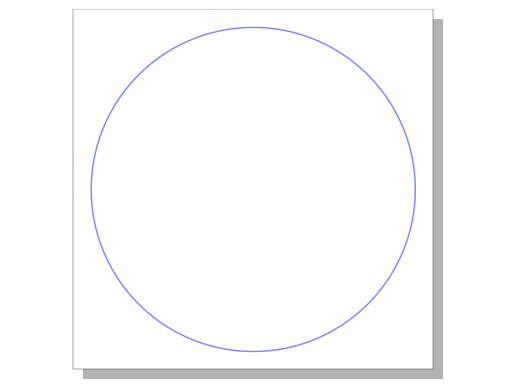

In [17]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale("1mm")
vsk.circle(0, 0, radius=45)
vsk.display()

Now let's add a rectangle with the `.rect()` method.

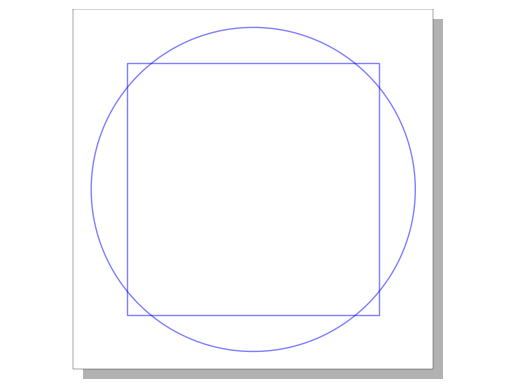

In [18]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale("1mm")
vsk.circle(0, 0, radius=45)
vsk.rect(-35, -35, 70, 70)
vsk.display()

The first two parameters of the `.circle()` function specify the X and Y coordinates of the center of the circle (in the same units you specified in `.scale()`). The first two parameters of `.rect()` specify the upper left-hand corner of the rectangle, and the second two parameters specify the width and height of the rectangle.

> Note: If you've used [Processing](https://processing.org/) or [p5.js](https://p5js.org/) before, you'll probably recognize the names of these shape methods and these conventions for specifying the positions of the shapes. Indeed, one of vsketch's advertised features is that its API is "strongly inspired" by Processing. Like Processing, you can also specify "modes" that change how these parameters function—see the [vsketch documentation for .rectMode(), for instance](https://vsketch.readthedocs.io/en/latest/autoapi/vsketch/index.html#vsketch.Vsketch.rectMode).

### Staying centered

By default, vsketch will automatically shift the "viewport" of your sketch so that whatever you've drawn is centered in the center of the page. For this reason, I find it convenient to treat `0, 0` as the origin of the page when composing sketches, but beware that `0, 0` might not always be the exact center. If you need the origin to be placed consistently, use the `center=False` option of `.size()` ([see the documentation for more details](https://vsketch.readthedocs.io/en/latest/autoapi/vsketch/index.html#vsketch.Vsketch.size)).

Here's another sketch that draws a series of random lines radiating from `0, 0`. This sketch demonstrates the `.line()` function, which takes four parameters: the first two are the X and Y coordinate of one endpoint of the line; the second two parameters are the other endpoint. (This sketch also demonstrates vsketch's auto-centering behavior described above—look closely at where the lines converge. Even though they're all technically at `0, 0`, the convergence point is not always in the exact center of the page itself.)

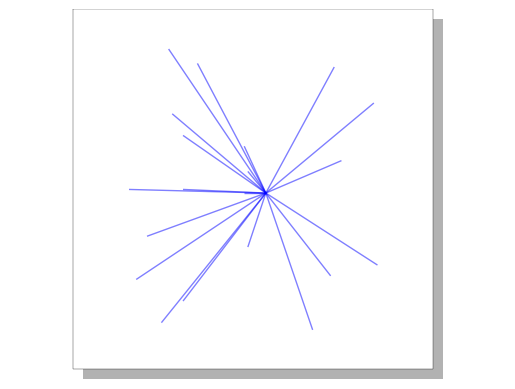

In [20]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale("1mm")
for i in range(20):
    vsk.line(0, 0, random.randrange(-40, 40), random.randrange(-40, 40))
vsk.display()

## Strokes, pens and fills

Because vsketch is designed primarily for pen plotters, its method for specifying strokes and fills of shapes is a little unusual. Unlike other vector graphics tools, which allow you to draw an arbitrary number of strokes and fills, with arbitrary colors, vsketch operates on a "pen" metaphor. The idea is that each "pen" constitutes a separate layer of the drawing, and that you might use different (physical, actual) pens for each layer. These pens are enumerated with strictly positive integers; you cannot (easily) change the colors that represent these pens in the preview drawings displayed with `.display()` (though of course you are welcome to choose the color of the actual physical pen that draws the layer when you actually plot the sketch!).

Here's an example that shows different shapes sketched with different pens, using the `.stroke()` method:

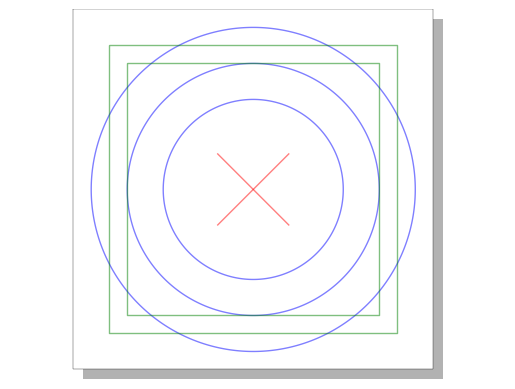

In [25]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale("1mm")
vsk.stroke(1) # select pen 1
vsk.circle(0, 0, radius=25)
vsk.circle(0, 0, radius=35)
vsk.circle(0, 0, radius=45)
vsk.stroke(2) # select pen 2
vsk.rect(-40, -40, 80, 80)
vsk.rect(-35, -35, 70, 70)
vsk.stroke(3) # select pen 3
vsk.line(-10, -10, 10, 10)
vsk.line(10, -10, -10, 10)
vsk.display()

As you can see, the pen selected with `.stroke()` applies to any shapes drawn afterwards, until `.stroke()` is called again with a different pen.

### Getting heavy and doubling down

You can set the weight of a stroke with `.strokeWeight()`, like so

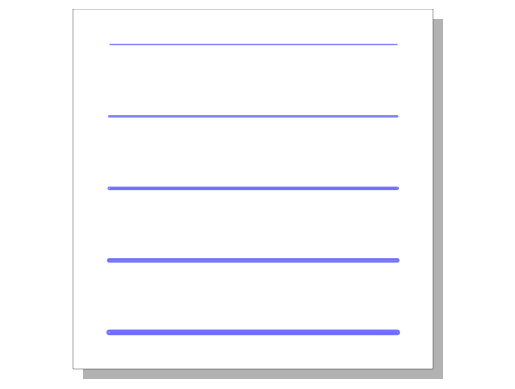

In [99]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale("1mm")
vsk.strokeWeight(1)
vsk.line(-40, -40, 40, -40)
vsk.strokeWeight(2)
vsk.line(-40, -20, 40, -20)
vsk.strokeWeight(3)
vsk.line(-40, 0, 40, 0)
vsk.strokeWeight(4)
vsk.line(-40, 20, 40, 20)
vsk.strokeWeight(5)
vsk.line(-40, 40, 40, 40)
vsk.display()

But the `.strokeWeight()` method in vsketch is a little misleadingly named. Again, we're planning on sending this drawing to a pen plotter, so we can't actually set the weight of the stroke: the pen of a pen plotter is either making contact with the paper, or it isn't. What `.strokeWeight()` actually does, behind the scenes, is draw the *same line multiple times*, with a small amount of distance between each duplicate line. This gives the impression of a thicker line. You can set the distance between each doubled stroke with the `.penWidth()` method:

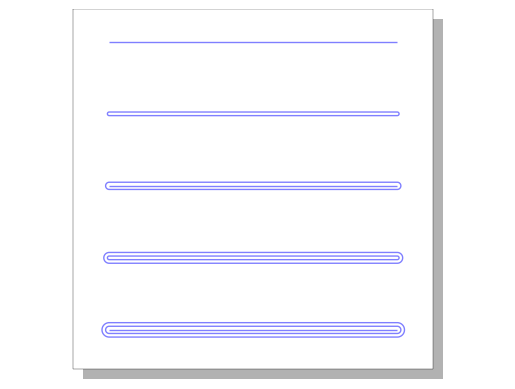

In [26]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale("1mm")
vsk.penWidth("1mm") # <- change this to increase the distance between doubled lines!
vsk.strokeWeight(1)
vsk.line(-40, -40, 40, -40)
vsk.strokeWeight(2)
vsk.line(-40, -20, 40, -20)
vsk.strokeWeight(3)
vsk.line(-40, 0, 40, 0)
vsk.strokeWeight(4)
vsk.line(-40, 20, 40, 20)
vsk.strokeWeight(5)
vsk.line(-40, 40, 40, 40)
vsk.display()

The idea of `.penWidth()` is that you would set it to *the actual width of the pen* attached to the pen plotter, so that the doubled lines overlap just enough to give the impression of forming a single line.

Each pen can have its width set individually. To do this, specify the pen whose width you want to set as the second parameter to `.penWidth()` (as an integer—the same one you would pass to `.stroke()`). Any time you draw with that pen, the stroke weight will use the width you set. The following example shows how this works. The example also demonstrates that `.penWidth()` applies to all shapes, not just lines!

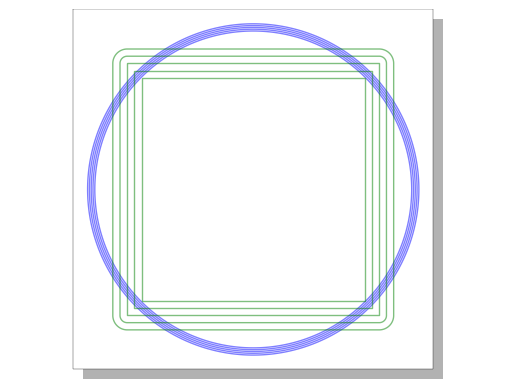

In [28]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale("1mm")
vsk.penWidth("0.5mm", 1) # spaces between doubled strokes for pen 1 will be 0.5mm apart
vsk.penWidth("2mm", 2) # spaces between doubled strokes for pen 2 will be 2mm
vsk.strokeWeight(5)
vsk.stroke(1)
vsk.circle(0, 0, radius=45)
vsk.strokeWeight(5)
vsk.stroke(2)
vsk.rect(-35, -35, 70, 70)
vsk.display()

### Fill 'er up

You can also fill shapes with vsketch. Use the `.fill()` command with a pen number to use that pen to fill the shape. The following example shows how it works:

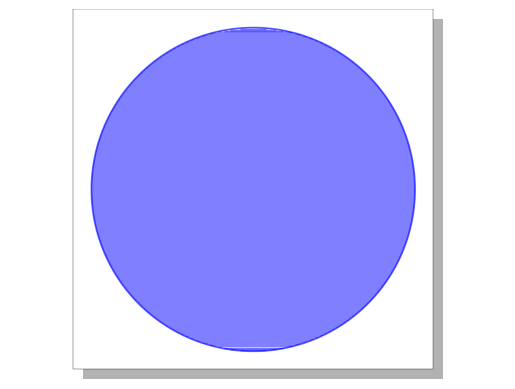

In [107]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale("1mm")
vsk.fill(1)
vsk.circle(0, 0, radius=45)
vsk.display()

Again, if you're used to the `.fill()` command in other 2D drawing frameworks—or even the concept of "fill color" in 2D vector art programs—then vsketch's way of doing things might be a bit bewildering! But it does makes sense, if you remember that vsketch is specifically designed for pen plotters. And pen plotters can't flood fill shapes! Instead, vsketch "simulates" filling a shape by drawing a dense back-and-forth pattern of lines. You can see what this looks like if you increase the pen width for the pen that you're using to fill the shape:

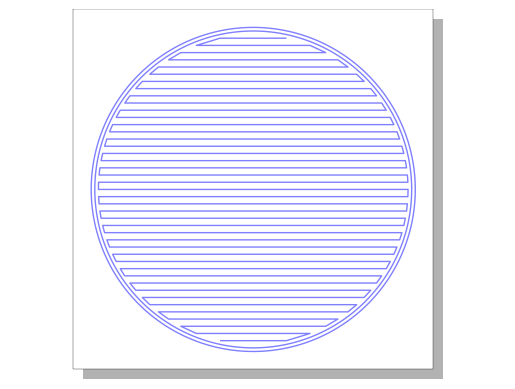

In [30]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale("1mm")
vsk.penWidth("2mm", 1)
vsk.fill(1)
vsk.circle(0, 0, radius=45)
vsk.display()

Imagine a pen with the given width following that zig-zag path: it would, indeed, create a "filled" shape.

The fill pen specified with `.fill()` applies to all shapes drawn subsequently in the sketch, until you apply another fill pen with `.fill()`. The following example shows two shapes with two different fills. Using overlapping fills with a little bit of space can create a pleasing transparency effect:

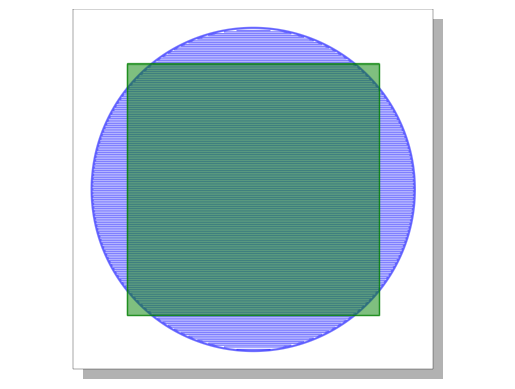

In [115]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale("1mm")
vsk.penWidth("0.5mm", 1)
vsk.penWidth("0.1mm", 2)
vsk.stroke(1)
vsk.fill(1)
vsk.circle(0, 0, radius=45)
vsk.stroke(2)
vsk.fill(2)
vsk.rect(-35, -35, 70, 70)
vsk.display()

### Saving to disk

If you make something with vsketch that you like, you can save it to disk for later use (e.g., to send it to the pen plotter). The `.save()` method of the `Vsketch` object saves the file as SVG with the specified filename:

In [186]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale("1mm")
vsk.circle(0, 0, radius=45)
vsk.rect(-35, -35, 70, 70)
vsk.save("test.svg")

You can open this SVG file with most vector editors (Inkscape, Illustrator, etc.).

## Preliminaries, part 2: Randomness with numpy

For the purposes of this tutorial, let's think about asemic writing as a kind of random process. Our method of generating asemic writing with a computer will be to simulate the random movement of a hand holding a pen. The movement of the pen is constrained in certain ways—i.e., at any point in the process, some pen movements are more likely to happen than other pen movements. To model this process, we need a way to generate random numbers.

Fortunately, the Numpy library has a wide variety of random number generators with different useful properties. Let's talk about a few of them.

### Uniform distribution

The `uniform()` function returns a number between 0 and 1, drawn from a "uniform distribution." The word "uniform" here means that every value in the domain has *the same chance of being generated*—no number or range of numbers is more likely than any other. Run the cell below multiple times to see what happens.

In [31]:
uniform()

0.23140643953215012

Using a `for` loop, you can generate a series of numbers to see what the distribution looks like. (You can change the number `8` to something larger to generate more numbers and better understand the distribution.)

In [32]:
for i in range(8):
    print(uniform())

0.4632498953737926
0.4452803288897945
0.123468088003718
0.34316498600245293
0.9081949425659804
0.05070314685402477
0.33326922431132333
0.6347711218957679


If you give two parameters to `uniform()`, the function will evaluate to a number chosen from that range (with the first parameter being the low end of the range, and the second parameter being the high end.)

In [33]:
for i in range(8):
    print(uniform(-5, 5))

3.579305779273854
4.362870386208709
2.565749695310692
4.575248656971114
-2.6216666173572567
-2.8181334530854727
-2.8348413203345113
3.551569591150871


If you need an integer instead of a floating-point number (i.e., a number with a decimal point), you can wrap the call to `uniform()` in a call to `int()`. The cell below simulates rolling a [twenty-sided die](https://en.wikipedia.org/wiki/Dice#Standard_variations):

In [34]:
for i in range(8):
    print(int(uniform(20)+1))

7
8
7
11
3
16
3
2


> Exercise: Why do we need to add one to the result of the `uniform()` function in the example above?

### Normal distribution

A random number generator with a normal distribution (also called the Gaussian distribution or the "bell curve") produces values mostly clustered around a particular number. When generating a random number with a normal distribution, you specify the "center" of the distribution (i.e., the number that the values will cluster around) and the value for the standard deviation of the distribution, which controls the "spread" of numbers returned, above and below the center. (~70% of numbers will be within this range; ~95% will be within double the range.) Generate a random number with a normal distribution using the `normal()` function:

In [35]:
normal(0, 2)

0.86779688210596

The first parameter is the center, and the second is the standard deviation. (These are often called *mu* and *sigma*, respectively.) Run it a number of times and you should see that the numbers generated mostly cluster around the center:

In [36]:
for i in range(8):
    print(normal(0, 2))

-1.3769082867959088
0.48028369070524457
-2.16710068359347
1.4123187374196726
-1.3457256528165238
2.9225796915697058
-2.045138402498463
1.0498638021570863


Normal distributions are very useful in computer-generated art because they allow us to introduce and control variation, keeping values mostly in the same range.

### Truncated normal distribution

You may have noticed that sometimes the random number generator for the normal distribution produces values well outside the standard deviation. That's not a bug—it's just how normal distributions work. (In any data set, there are sometimes extreme outliers.)

Nevertheless, in computer-generated art there's often a need to generate random numbers from a normal distribution that are *constrainted* to a particular range. (For example, you might want to generate a random color with a normal distribution, but never want your color values to fall outside of the range 0–255.) For this, you can use a *truncated normal distribution*. The following cell defines a function `t_normal()` to produce such values.

In [37]:
from scipy.stats import truncnorm
def t_normal(a, b, mu, sigma):
    tn = truncnorm((a-mu)/sigma, (b-mu)/sigma, loc=mu, scale=sigma)
    return tn.rvs(1)[0]

The first parameter is the low end of the range, the second parameter is the high end, the third parameter is the center and the fourth parameter is the standard deviation.

In [38]:
t_normal(0, 255, 10, 10)

11.046983852481679

### Choosing from a list with probabilities

The `choice()` function implements a kind of *weighted* random choice, where you can set the weights randomly. The code in the cell below picks one of `50`, `100` or `150` (the values between the first set of brackets). It will pick these with 15% probability, 80% probability, and 5% probability respectively (as specified by the values between the second set of brackets).

In [39]:
choice([50, 100, 150], p=[0.15, 0.8, 0.05])

100

Calling this function multiple times should result in the specified distribution:

In [40]:
for i in range(8):
    print(choice([50, 100, 150], p=[0.15, 0.8, 0.05]))

100
100
150
100
100
100
100
100


Without the `p` parameter, the `choice()` function defaults to a uniform distribution (i.e., no result is more likely than any other):

In [41]:
for i in range(8):
    print(choice([50, 100, 150]))

150
100
150
50
100
100
50
150


The `sample()` function (from Python's standard `random` module) takes a list of values and returns the specified number of values, randomly selected (using a uniform distribution) from the list.

In [42]:
from random import sample

In [43]:
sample([5, 10, 15, 20], 2)

[5, 10]

### Visualizing distributions with vsketch

The code in the cell below places circles on a page with the (x, y) coordinates of their centers determined by different random distributions. The light circles drawn with pen 1 are uniformly distributed; the medium stroked circles drawn with pen 2 are normally distributed; and the thick circles drawn with pen 3 are in a truncated normal distribution (centered on the center of the page, with the same spread.) You can see that the uniformly-distributed circles are spread more or less evenly across the page; the normal distributed circles are clustered in the center and taper off in all directions; the truncated normal also cluster and taper but stay within a rectangular area.

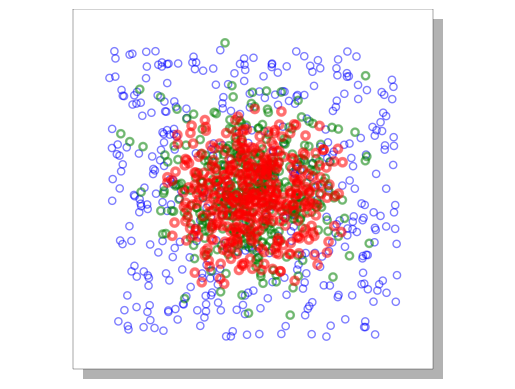

In [46]:
mu = 0 # center of normal distributions
sigma = 12 # standard deviation of normal distributions
sample_n = 400 # number of "samples" (i.e. circles to draw for each distribution)

vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale("1mm")

vsk.stroke(1)
vsk.strokeWeight(1)
for i in range(sample_n):
    vsk.circle(uniform(-40, 40), uniform(-40, 40), 2)
    
vsk.stroke(2)
vsk.strokeWeight(2)
for i in range(sample_n):
    vsk.circle(normal(mu, sigma), normal(mu, sigma), 2)
    
vsk.stroke(3)
vsk.strokeWeight(3)
for i in range(sample_n):
    vsk.circle(t_normal(-25, 25, mu, sigma), t_normal(-25, 25, mu, sigma), 2)
    
vsk.display()

> Exercise: Copy the visualization above, but rewrite it to visualize three normal distributions with different standard deviations.

## Random compositions

Now we have the tools to use randomness to make some plotter compositions. Here are some examples—feel free to modify them and make them your own!

Rectangles with truncated normal positions, uniform sizes, uniform pen widths:

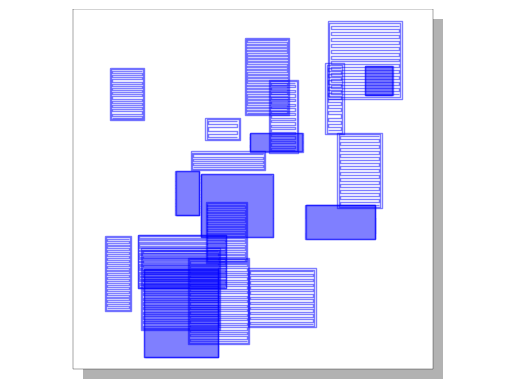

In [182]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale("1mm")

for i in range(20):
    vsk.penWidth(f"{uniform(0.1, 1)}mm")
    vsk.fill(1)
    vsk.rect(t_normal(-40, 40, 0, 20), t_normal(-40, 40, 0, 20),
             uniform(5, 25), uniform(5, 25))

vsk.display()

Similar example, with circles, switching between different pens:

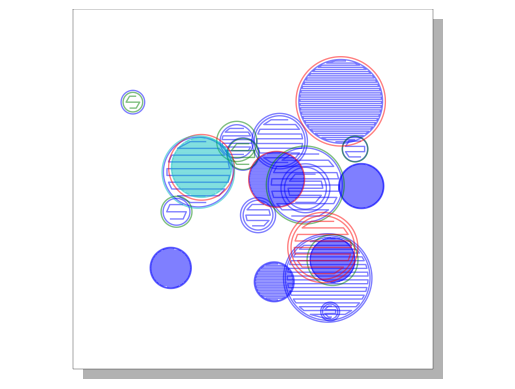

In [60]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale("1mm")

for i in range(20):
    stroke_pen = choice([1, 2, 3, 4], p=[0.6, 0.2, 0.1, 0.1])
    fill_pen = choice([1, 2, 3, 4], p=[0.6, 0.2, 0.1, 0.1])
    vsk.stroke(stroke_pen)
    vsk.fill(fill_pen)
    vsk.penWidth(f"{uniform(0.1, 2)}mm", stroke_pen)
    vsk.penWidth(f"{uniform(0.1, 2)}mm", fill_pen)
    vsk.circle(t_normal(-40, 40, 0, 20), t_normal(-40, 40, 0, 20),
             uniform(5, 25))

vsk.display()

> Exercise: Write code to generate random compositions by copying one of the cells above and modifying the parameters. Also try adding in new shapes or combining different kinds of shapes.

> Exercise: Can you figure out how to make the "page" bigger? How do you need to adjust the parameters in the random number-generating functions to compensate?

## The line

Okay. Now that we have the preliminaries out of the way, we can get to work making computational asemic glyphs. We'll start with the most basic component of written language: the line segment. A line segment connects two points. The easiest way to specify a line segment is with two points: where the line starts, and where the line ends. You can draw one using vsketch like this:

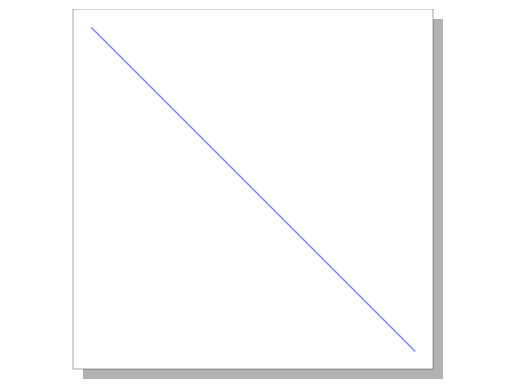

In [61]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale("1mm")
vsk.line(-45, -45, 45, 45)
vsk.display()

As discussed above, the `.line()` method takes four parameters: the first two are the X/Y coordinates of the first point of the line segment, and the second two are the X/Y coordinates of the other point.

Perhaps the most elementary computational asemic glyph would be uniformly distributed scratch marks, which we can generate in vsketch like so:

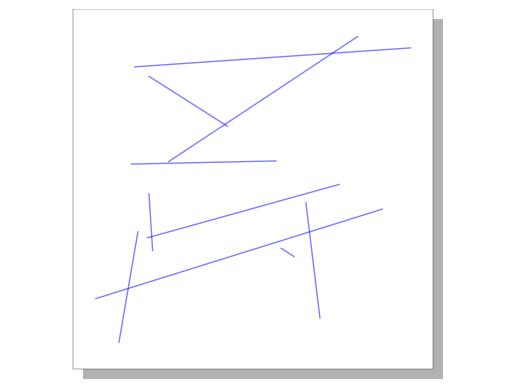

In [64]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale("1mm")
for i in range(10):
    vsk.line(uniform(-45, 45), uniform(-45, 45), uniform(-45, 45), uniform(-45, 45))
vsk.display()

### The polyline

That's not terribly satisfying, though. A first approximation of the structure of written characters might be that they consist of *sequences* of line segments, each starting at the end of the last. The term in computer graphics for such a sequence of connected lines is a `polyline`. In these examples, I will (generally) represent polylines as lists of lists, where the "outer" list contains many smaller lists that each have two elements, like so:

In [80]:
pline = [[10, -30], [-20, 10], [-10, 30], [45, 45]]

This data structure is meant to represent a polyline with three segments, the first of which begins at `-10, -30` and the last of which ends at `45, 45`. (You need $n + 1$ points to represent a polyline with $n$ segments.) To draw a polyline, use vsketch's `.polygon()` function, like so:

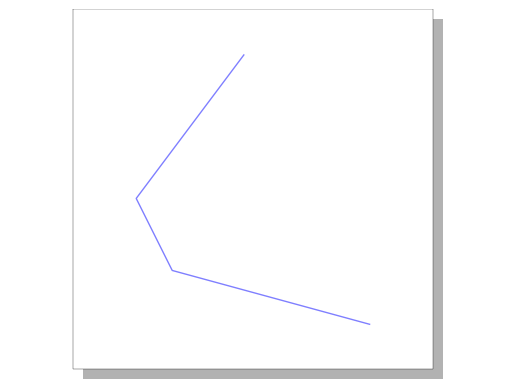

In [82]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale("1mm")
vsk.polygon(pline)
vsk.display()

That's not a typo—you use `.polygon()` to draw a polyline! Polylines and polygons are essentially the same thing, except that a polygon is closed—the last point connects back to the first. You can close a polyline into a polygon either by repeating the first point of the polyline at the end of the list, or using the `close=True` parameter of the `.polygon()` method:

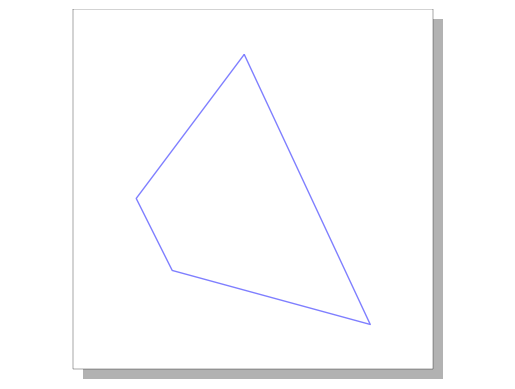

In [83]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale("1mm")
vsk.polygon(pline, close=True)
vsk.display()

### Transformations with vsketch

The `vsketch` library supports affine transformations like translation, rotation, scale, etc. If you're familiar with p5js and need a refresher on affine transformations, [here's a tutorial you can follow](https://creative-coding.decontextualize.com/transformations-and-functions/); I also recommend the ever-charismatic Dan Shiffman's [Coding Train tutorial](https://www.youtube.com/watch?v=o9sgjuh-CBM). The means of applying these transformations in `vsketch` is very similar to how you do so in Processing and p5js.

Any translation in `vsketch` begins with the line `with vsk.pushMatrix():` (replacing `vsk` with whatever you happened to call your `Vsketch` object.) At the beginning of the `with` block, the current transformation matrix will be saved; at the end of the block, the previous transformation matrix will be restored (equivalent to calling `.popMatrix()`).

#### Translation

Let's take a look in more detail!

First, the `.translate()` method moves the origin of the coordinate system by the X and Y distances specified in its two parameters. Here is the original polyline, plus its translation:

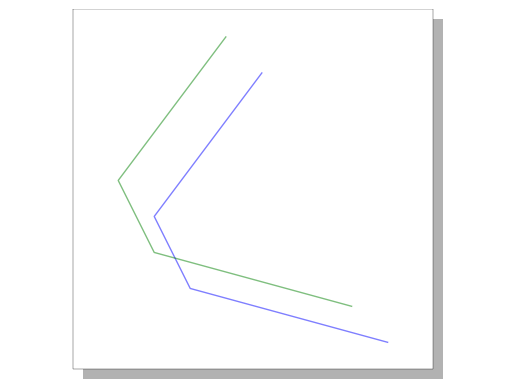

In [86]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale("1mm")
with vsk.pushMatrix():
    vsk.stroke(2)
    vsk.translate(10, 10)
    vsk.polygon(pline)
vsk.stroke(1)
vsk.polygon(pline)
vsk.display()

#### Rotation

The `.rotate()` method rotates the coordinate system around its origin by the specified angle in [radians](https://en.wikipedia.org/wiki/Radian):

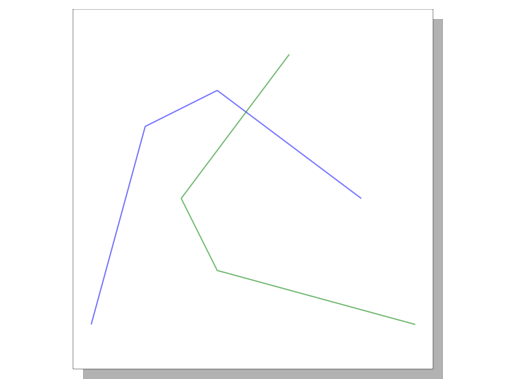

In [91]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale("1mm")
with vsk.pushMatrix():
    vsk.stroke(2)
    vsk.rotate(np.pi * 0.5)
    vsk.polygon(pline)
vsk.stroke(1)
vsk.polygon(pline)
vsk.display()

If you're using `numpy` (imported as `np`, as in this notebook), you can get the value of $\pi$ like so (in radians, $\pi$ is halfway around the circle):

In [92]:
np.pi

3.141592653589793

If you are among the brave souls who prefer degrees to radians, you can convert from degrees to radians using `np.radians()`:

In [94]:
np.radians(90)

1.5707963267948966

#### Scale

The `.scale()` method scales the coordinate system of the sketch by the specified factor. The following cell shows this same polyline alongside a copy that has been scaled to three-quarters size:

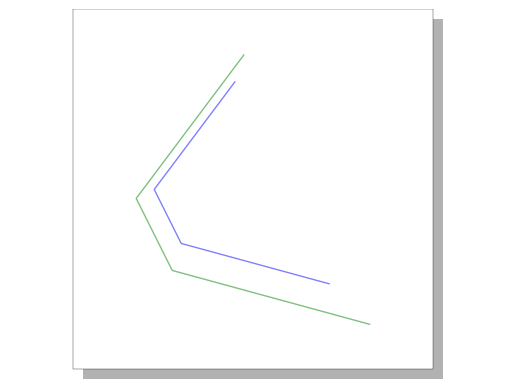

In [100]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale("1mm")
with vsk.pushMatrix():
    vsk.stroke(2)
    vsk.scale(0.75)
    vsk.polygon(pline)
vsk.stroke(1)
vsk.polygon(pline)
vsk.display()

The `.scale()` method can also take two parameters, if you want to scale the X and Y axes differently:

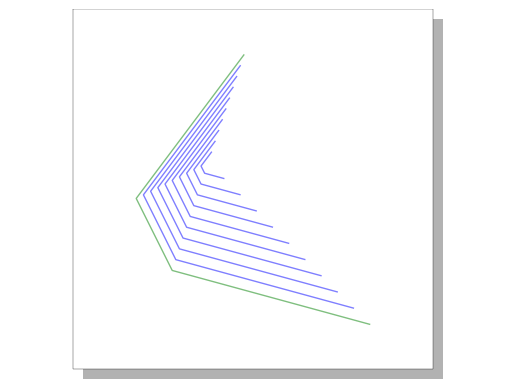

In [102]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale("1mm")
for i in range(10):
    with vsk.pushMatrix():
        vsk.stroke(2)
        vsk.scale(i * 0.1)
        vsk.polygon(pline)
vsk.stroke(1)
vsk.polygon(pline)
vsk.display()

### Generating random polylines

In this notebook, we're concerned with generating asemic writing. To do this, we need to generate figures that resemble written characters. We'll accomplish this by generating polylines at random.

A polyline is simply a sequence of points, which we can generate in a `for` loop. The following cell creates a polyline from ten points whose x- and y- coordinates are drawn from a uniform distribution between -0.5 and 0.5:

In [110]:
pts = []
for i in range(10):
    pts.append([uniform(-0.5, 0.5), uniform(-0.5, 0.5)])

> Note: Advanced users might instead use fancy `numpy` shortcuts like `uniform(-0.5, 0.5, size=(10, 2))`. The goal is to end up with an iterable where each element is itself a sequence with two elements.

You can examine the values of the polylines points by simply evaluating the variable:

In [111]:
pts

[[0.11353489942446049, -0.008750755648602393],
 [0.07832898807422384, -0.1321953239896888],
 [0.05150372163783046, -0.17504143744360268],
 [-0.4441466565248344, -0.1517677969665211],
 [-0.13702865558615873, -0.3472831889665403],
 [-0.4101532999061327, 0.16920984361573965],
 [-0.047233678248851274, 0.0669823929812845],
 [0.009161510094526482, 0.4106187981850301],
 [0.1656225425254706, -0.06637376151288965],
 [-0.4823279816497664, -0.48329054098160906]]

This polyline will be too small for us to see in detail if we were to draw it directly, both because all of the points are less than one. We'll use `.scale()` to scale the polyline up to a visible size:

Here's what it looks like:

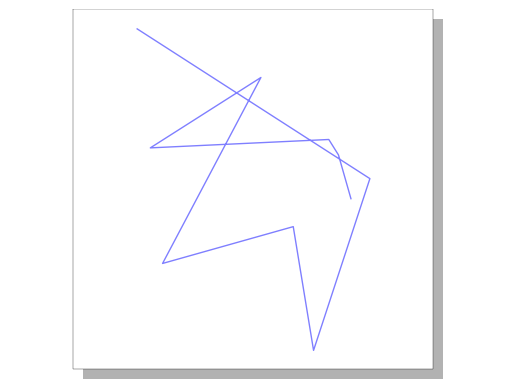

In [113]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale("1mm")
with vsk.pushMatrix():
    vsk.scale(100)
    vsk.polygon(pts)
vsk.display()

> "Wait," you say. "If we're going scale it up anyway, why not just use a bigger upper limit on the random numbers when you generate the points?" Good question! Whenever I'm writing code that generates stuff, I prefer to write it such that the figures it produces are "unit scale," i.e., are sized so that the figures are 1 unit across. The reason for this is that it lets me separate the logic of the generator from the logic of how the generated data gets displayed. If I work at unit scale and use the `.scale()` method, I can use the same generator to create small characters and large characters, without having to modify the underlying generator code. That's a handy bit of flexibility. Generating the figures with their center point at `(0, 0)` is a more aesthetic decision; in this case, it lets us rotate the figures around their centers easily.

#### A function for generating random polylines

The following cell defines a [Python function](https://docs.python.org/3/tutorial/controlflow.html#defining-functions) that returns a randomly generated polyline using the technique discussed above. The function takes a single parameter, which you can use to specify the number of segments to be added at random to the polyline.

In [114]:
def uniform_glyph(n=10):
    pts = []
    for i in range(n):
        pts.append([uniform(-0.5, 0.5), uniform(-0.5, 0.5)])
    return pts

The following cell uses this function to generate a large number of glyphs, and draws them to the canvas at random places with random sizes:

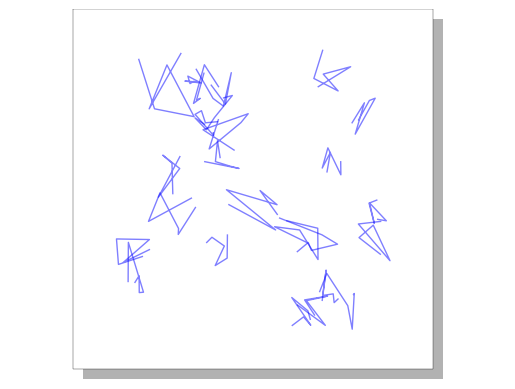

In [135]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale("1mm")
for i in range(25):
    with vsk.pushMatrix():
        vsk.translate(uniform(-40, 40), uniform(-40, 40))
        vsk.scale(uniform(5, 20))
        vsk.polygon(uniform_glyph(6))
vsk.display()

Nice! This still doesn't quite look like writing, but I think we're on the right path. Play around with the various numbers (e.g., the parameter passed to `uniform_glyph()`) to get a handle on how this works.

#### Giving a bit of structure to glyphs

The following function is a variation on `uniform_glyph()` above that starts each glyph with a single line at its baseline, in order to lend the glyphs it produces some kind of shared structure and repetition. This is an easy way to make the glyphs look less like random lines and more like "writing":

In [132]:
def uniform_glyph_baseline(n=10):
    pts = [[-0.4, 0.5], [0.4, 0.5]]
    for i in range(n):
        pts.append([uniform(-0.5, 0.5), uniform(-0.5, 0.5)])
    return pts

Here's the same code as above, using the `uniform_glyph_baseline()` function instead:

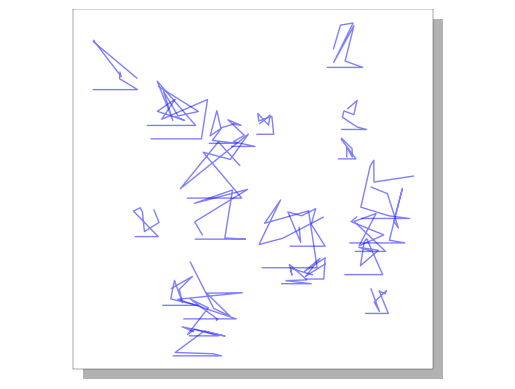

In [134]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale("1mm")
for i in range(25):
    with vsk.pushMatrix():
        vsk.translate(uniform(-40, 40), uniform(-40, 40))
        vsk.scale(uniform(5, 20))
        vsk.polygon(uniform_glyph_baseline(6))
vsk.display()

## Forays into layout

The previous example follows the general overall structure we'll be using for the remainder of our asemic writing experiments. That structure is:

* Devise a strategy for producing a single glyph at unit scale. (In the case of the previous example, the glyph is a polyline of points drawn from a uniform distribution.)
* Write a function to implement the glyph-generating strategy.
* Write some code to "lay out" the glyphs on the page. (In the case of the previous example, the "layout" code is simply drawing the glyphs one by one on the canvas at random positions.)

If we want to refine our results, we can refine (a) the strategy for producing glyphs and/or (b) the strategy for laying out the glyphs on the page. Let's start with some layout strategies.

### Glyphs on a grid

Laying characters from real languages out on a page is a tremendously complicated task! Fortunately, if we're generating the glyphs ourselves, we can make certain assumptions that make the process easier.

One simple method of glyph layout placing glyphs on a grid. To do this, you can use a `for` loop to produce `x, y` coordinates for each position on the grid, then generate a glyph and translate it to that position. The following example produces a 10x10 grid of glyphs on the page using nested `for` loops:

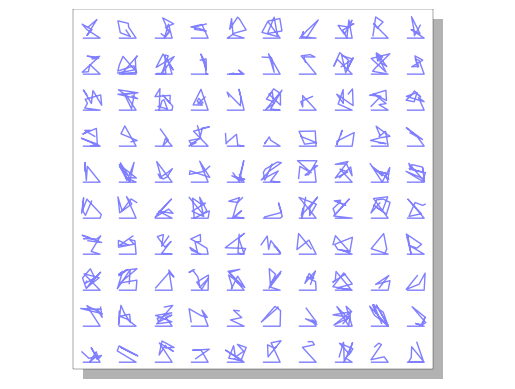

In [140]:
# parameters for the grid---play with these values!
width = 100
height = 100
grid_size = 10

# calculate how large each "cell" of the grid is
cell_size_x = width / grid_size
cell_size_y = height / grid_size

# how much to scale the grid: size of cell times a multiplier
# (multiplier controls how much space in the cell the glyph will take up)
scale_val = (width / grid_size) * 0.6

vsk = vsketch.Vsketch()
vsk.size(f"{width}mm", f"{height}mm")
vsk.scale("1mm")

for i in range(grid_size):
    for j in range(grid_size):
        glyph = uniform_glyph_baseline(random.randrange(4, 12))
        with vsk.pushMatrix():
            vsk.translate(i * cell_size_x, j * cell_size_y)
            vsk.scale(scale_val)
            vsk.polygon(glyph)

vsk.display()

#### Variation 1: Staggered grids

Grids are a very easy way to lay out glyphs. To my eye, though, a grid also strongly suggests east Asian forms of writing (Hanzi, Kanji, Hangul, etc.), which can lend an unwanted air of orientalism to an asemic work. One way to break this up is to stagger the grid a little bit. The following example is identical to the above, except it adds an offset to each row based on whether the row has an even or odd number:

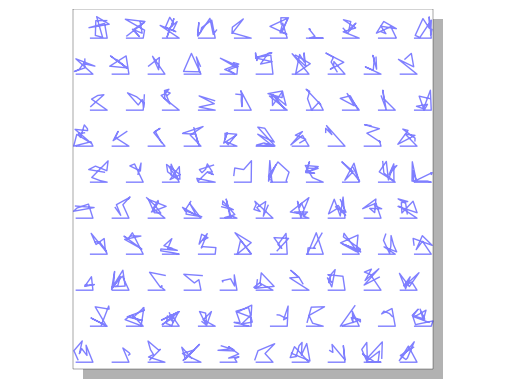

In [141]:
width = 100
height = 100
grid_size = 10

cell_size_x = width / grid_size
cell_size_y = height / grid_size

scale_val = (width / grid_size) * 0.6

vsk = vsketch.Vsketch()
vsk.size(f"{width}mm", f"{height}mm")
vsk.scale("1mm")

for i in range(grid_size):
    for j in range(grid_size):
        glyph = uniform_glyph_baseline(random.randrange(4, 12))
        with vsk.pushMatrix():
            x_translate = i * cell_size_x
            if j % 2 == 0:
                x_translate += scale_val * 0.33
            else:
                x_translate -= scale_val * 0.33
            vsk.translate(x_translate, j * cell_size_y)
            vsk.scale(scale_val)
            vsk.polygon(glyph)

vsk.display()

#### Variation 2: Adding spaces

There are a number of ways we can add variation to the grid to make it seem more natural. One is to leave spaces between the items in the grid, in order to give the appearance of separate words. The easiest way to do this is to optionally leave a grid space empty if a random number doesn't meet a particular threshold:

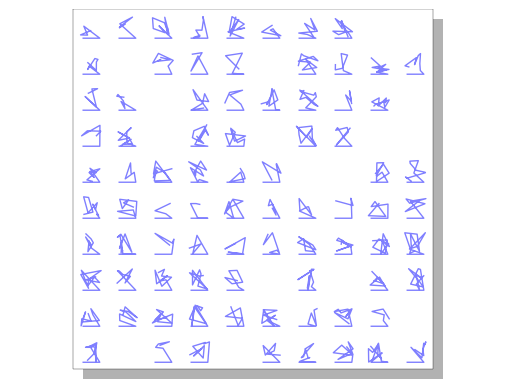

In [142]:
width = 100
height = 100
grid_size = 10

cell_size_x = width / grid_size
cell_size_y = height / grid_size

scale_val = (width / grid_size) * 0.6

vsk = vsketch.Vsketch()
vsk.size(f"{width}mm", f"{height}mm")
vsk.scale("1mm")

for i in range(grid_size):
    for j in range(grid_size):
        # only draw the glyph here by luck of the draw
        if uniform() < 0.85: 
            glyph = uniform_glyph_baseline(random.randrange(4, 12))
            with vsk.pushMatrix():
                vsk.translate(i * cell_size_x, j * cell_size_y)
                vsk.scale(scale_val)
                vsk.polygon(glyph)

vsk.display()

Another option is to add a ragged bottom margin by looping only up to a random number of times on the `x` axis:

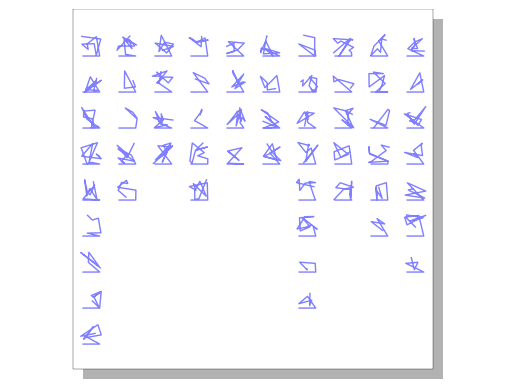

In [146]:
width = 100
height = 100
grid_size = 10

cell_size_x = width / grid_size
cell_size_y = height / grid_size

scale_val = (width / grid_size) * 0.6

vsk = vsketch.Vsketch()
vsk.size(f"{width}mm", f"{height}mm")
vsk.scale("1mm")

for i in range(grid_size):
    for j in range(random.randrange(4, grid_size)):
        glyph = uniform_glyph_baseline(random.randrange(4, 12))
        with vsk.pushMatrix():
            vsk.translate(i * cell_size_x, j * cell_size_y)
            vsk.scale(scale_val)
            vsk.polygon(glyph)

vsk.display()

> Exercise: Make the above example have a "ragged" right margin by swapping the `i` and `j` loop variables. Why does this work?

### Advanced: "Typesetting" glyphs with variable widths

Another way to lay out glyphs is one by one, in rows, like typesetting text in Roman alphabets. This technique is especially useful when you're working with glyphs that don't have a uniform width. The algorithm for performing this makes use of two variables, `current_x` and `current_y`, which essentially act as the position of the "cursor." Before drawing a glyph to the canvas, the algorithm checks to see if `current_x` plus glyph's width would be greater than the width of the canvas. If so, the algorithm resets `current_x` to zero and increments `current_y` by the height of the line, causing the glyph (and subsequent glyphs) to be drawn on the next line.

The `uniform_glyph_baselines()` function defined above produce glyphs of uniform width (on average, at least), so for this exercise we'll need to refine the function so that it can return glyphs with variable width. The function below does exactly this! The `width` parameter controls the extent of the baseline along the X axis, as well as the random numbers drawn for the rest of the glyph. In this case, because we want all of the glyphs to start at the same point on the left margin, the glyph is constructed with the origin in the lower left-hand corner, instead of the center:

In [160]:
def baseline_glyph_varwidth(n=10, width=1.0):
    pts = [[0, 0], [width, 0]]
    for i in range(n):
        pts.append([uniform(0, width), uniform(0, -1)])
    return pts

The following sketch demonstrates the function, showing glyphs with increasing widths:

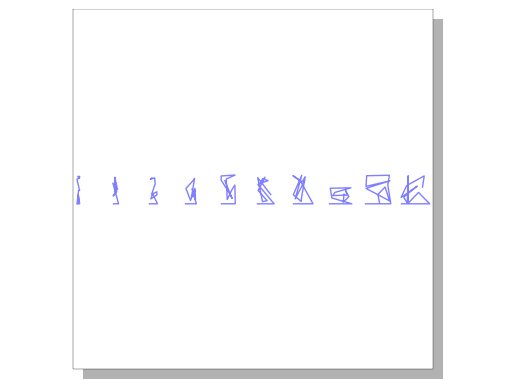

In [161]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale("1mm")

for i in range(10):
    with vsk.pushMatrix():
        vsk.translate(-40 + (i*10), 0)
        vsk.scale(8)
        vsk.polygon(baseline_glyph_varwidth(10, (i+1)/10))

vsk.display()

I am going to generate the widths of the glyphs first. This makes the layout process a bit easier:

In [171]:
glyph_count = 100
glyph_widths = [choice([0.2, 0.333, 0.667, 1], p=[0.1, 0.5, 0.3, 0.1]) for i in range(glyph_count)]

Here are the first few values from the list, just so you get an idea what they look like:

In [172]:
glyph_widths[:12]

[0.333, 0.333, 0.333, 0.333, 1.0, 0.667, 0.333, 0.667, 0.2, 0.2, 0.333, 0.667]

The following code performs the "typesetting." I've left comments in the code to help explain how everything works.

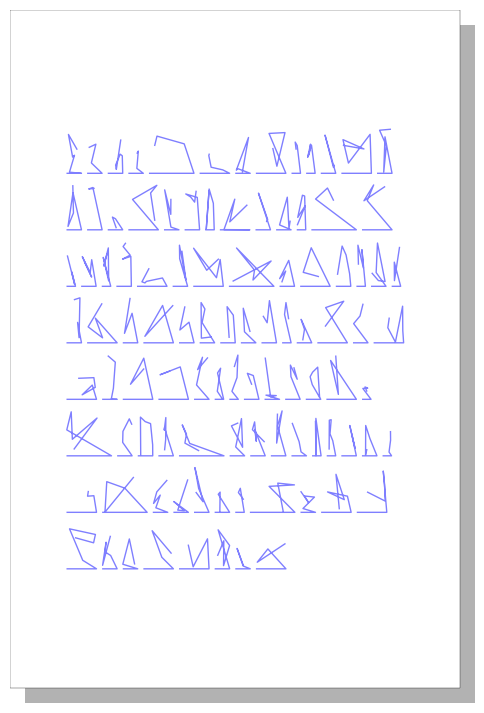

In [272]:
width = 80
height = 120

margin = 10

vsk = vsketch.Vsketch()
vsk.size(f"{width}mm", f"{height}mm")
vsk.scale("1mm")

# cursor values
current_x = 0
current_y = 0

em_width = 8 # width of glyph
em_height = 8 # height of glyph 
line_height = 10 # spacing between lines
kerning = 1 # spacing between glyphs

# iterate over our list of randomly generated glyph width multipliers
for width_factor in glyph_widths:
    
    # generate the glyph with this width
    glyph = baseline_glyph_varwidth(random.randrange(3, 6), width_factor)
    
    # the actual width of the glyph on screen
    g_width = em_width * width_factor
    
    # if this glyph would overflow the line, skip back to beginning
    # and move to next line
    # margin*2 because there are left and right margins!
    if current_x + g_width > (width - margin*2):
        current_x = 0
        current_y += line_height
    if current_y > height:
        break
    with vsk.pushMatrix():
        # find the appropriate position
        vsk.translate(current_x + margin, current_y + margin + em_height)
        # scale up from unit scale
        vsk.scale(em_width)
        # draw it!
        vsk.polygon(glyph)
    # advance the cursor, include some space between each glyph
    current_x += g_width + kerning
vsk.display(fig_size=(6, 9))

> Exercise: Add some code to the above example to add spaces between glyphs at random intervals.

> Exercise: Most (all?) writing systems consist of discrete sets of glyphs—not an infinite number of potential glyphs. Change the code in the above exercise so that it draws from a fixed set of (e.g.) 26 glyphs, instead of randomly generating a glyph for each position.

## Glyph structure

There is no one formula for generating glyphs that look "like writing." Your own approach to doing this might result from a study of the shapes of an existing writing system, or from experimentation with your own aesthetic preferences. In general, though, writing systems exhibit two properties: *structure* and *repetition*. When looking at glyphs in writing systems, you tend to see shapes, curves, and angles that are repeated not just in individual glyphs, but across many different glyphs in the same writing system.

### Grid glyphs

Our goal is to write code that can produce randomly generated glyphs that exhibit these two properties. An easy strategy for this is to place points of the polyline not at random, but on a grid. The grid constraints the randomness and ensures that characters have angles and shapes that repeat among them. The code below generates a random polyline, but constrains the points in the polyline to begin and end on certain points in the grid:

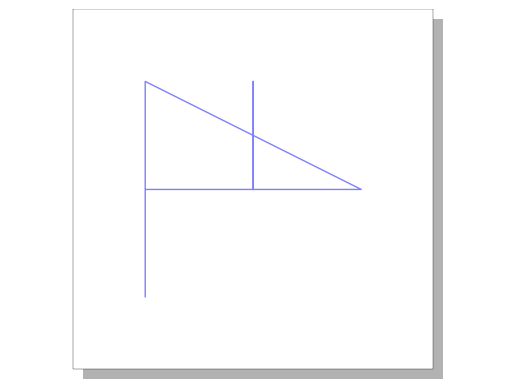

In [181]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale("1mm")

pts = []
for i in range(7):
    x = choice([-0.5, 0, 0.5])
    y = choice([-0.5, 0, 0.5])
    pts.append([x, y])
with vsk.pushMatrix():
    vsk.scale(60)
    vsk.polygon(pts)
vsk.display()

The key bit of code here is:

In [182]:
choice([-0.5, 0, 0.5])

0.5

... which is a Python expression that returns one of `-0.5`, `0`, and `0.5` (at random). Using this expression for both the `x` and `y` coordinate of each point on the polyline leads to a result wherein each polyline randomly connects one of nine points on a grid.

The cell below defines a function, `grid_glyph()`, that generates a series of points using a more general version of this expression. It adds four to twelve segments to the polyline (randomly determined).

In [183]:
def grid_glyph():
    pts = []
    for i in range(int(t_normal(4, 12, 8, 2))):
        x = (choice([-0.5, 0, 0.5]))
        y = (choice([-0.5, 0, 0.5]))
        pts.append([x, y])
    return pts

The results of the `grid_glyph()` function:

In [184]:
grid_glyph()

[[-0.5, -0.5],
 [0.5, 0.5],
 [0.5, -0.5],
 [0.5, -0.5],
 [0.5, -0.5],
 [0.0, 0.0],
 [-0.5, -0.5]]

The following cell draws these glyphs on a grid, so we can see many variations at once:

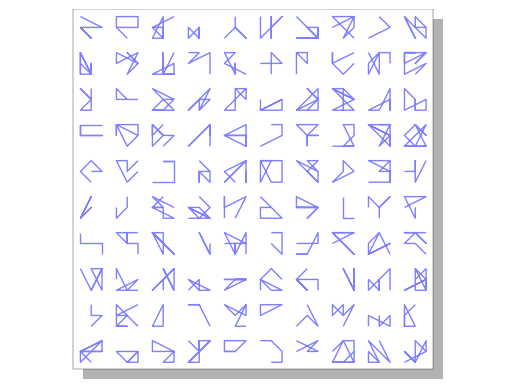

In [186]:
width = 100
height = 100
grid_size = 10

cell_size_x = width / grid_size
cell_size_y = height / grid_size

scale_val = (width / grid_size) * 0.6

vsk = vsketch.Vsketch()
vsk.size(f"{width}mm", f"{height}mm")
vsk.scale("1mm")

for i in range(grid_size):
    for j in range(grid_size):
        glyph = grid_glyph()
        with vsk.pushMatrix():
            vsk.translate(i * cell_size_x, j * cell_size_y)
            vsk.scale(scale_val)
            vsk.polygon(glyph)
vsk.display()

Now we're getting somewhere. When your sci-fi author friend texts you and says "Hey, I need something that looks like a writing system for space aliens for the cover of my next book," you've got something all ready to go.

> Exercise: Can you make these polylines fall on a 4x4 grid instead of a 3x3 grid? Or a 5x5 grid?

> Exercise: Add some randomness to each point's placement, so not all points fall directly on the grid.

> Exercise: Change the aspect ratio of the "characters"—make them wider than they are tall, or taller than they are wide.

## Interpolating curves

Due to certain properties of human physiology, handwriting hardly ever consists of exactly straight lines. To simulate the curved lines of conventional handwriting, we need to find a way to change our polylines into *curves*. One way of doing this is a [Catmull-Rom spline](https://en.wikipedia.org/wiki/Centripetal_Catmull%E2%80%93Rom_spline), which produces a sequence of [Bézier curves](https://pomax.github.io/bezierinfo/) that pass through a given set of points. Bezmerizing `Polyline` objects have a method `catmull_spline()` that uses Catmull-Rom to produce a polyline that approximates a curve through the given points.

To demonstrate, we'll create a polyline from uniform points:

In [194]:
pts = uniform_glyph_baseline()

And then use the following code to produce a smooth path between the points:

In [189]:
curve_pts = bezmerizing.Polyline(pts).catmull_spline().to_polyline(10)

The parameter of `.to_polyline()` controls the number of samples that the method takes along each segment of the spline. Increase this number for smoother curves.

The result is a big old list of points:

In [191]:
curve_pts

[[0.4, 0.5],
 [0.382204198202346, 0.48125330359171153],
 [0.32696599741073107, 0.45825920479044274],
 [0.24357700965783918, 0.4313050476988795],
 [0.14132884697635442, 0.40067817641970827],
 [0.029513121398960937, 0.36666593505561534],
 [-0.08257855504165688, 0.3295556677092869],
 [-0.1856545703128151, 0.2896347184834094],
 [-0.2704233123818296, 0.247190431480669],
 [-0.3275931692160162, 0.202510150803752],
 [-0.3275931692160162, 0.202510150803752],
 [-0.3614932617914443, 0.14700871014620356],
 [-0.38357976262883303, 0.07610618225211006],
 [-0.3952516370124722, -0.003902230200030582],
 [-0.39790785022665165, -0.08672132453172043],
 [-0.3929473675556614, -0.16605589806446147],
 [-0.3817691542837913, -0.23561074811975555],
 [-0.3657721756953315, -0.2890906720191049],
 [-0.34635539707457164, -0.32020046708401145],
 [-0.3249177837058018, -0.3226449306359772],
 [-0.3249177837058018, -0.3226449306359772],
 [-0.29600050943511874, -0.2871376033628989],
 [-0.25547519590128104, -0.21533045828722

If we draw the two of these together, we can see that the result of the Catmull-Rom spline is a smooth path that connects all of the points in the original polyline:

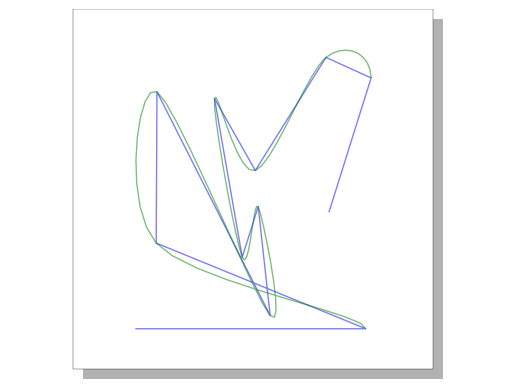

In [193]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale("1mm")
with vsk.pushMatrix():
    vsk.scale(80)
    vsk.stroke(1)
    vsk.polygon(pts)
    vsk.stroke(2)
    vsk.polygon(curve_pts)
vsk.display()

### Catmull-Rom tightness

The `.catmull_spline()` function takes a parameter `tightness` that controls the "tightness" of the spline. At `1` tightness, there is no curvature through the points at all; at `0`, the curvature is at its most curvy. You can use values outside this range—I like a tightness of `-0.5`. Above `1`, the curves start to form loops, which can be an interesting effect. Play with the `tightness` parameter in the example below to see how it works:

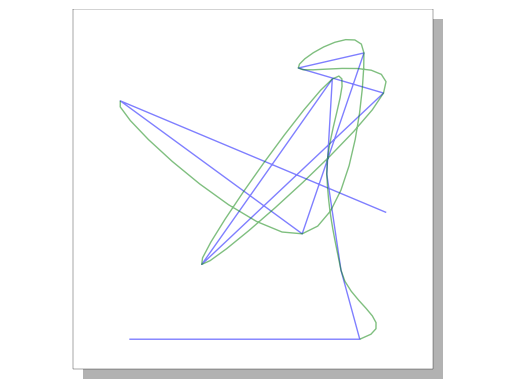

In [202]:
pts = uniform_glyph_baseline()
curve_pts = bezmerizing.Polyline(pts).catmull_spline(tightness=-0.25).to_polyline(10)

vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale("1mm")
with vsk.pushMatrix():
    vsk.scale(80)
    vsk.stroke(1)
    vsk.polygon(pts)
    vsk.stroke(2)
    vsk.polygon(curve_pts)
vsk.display()

### Dealing with eaten points

You'll notice in the above example that the Catmull-Rom spline algorithm "eats" the first and last points of the polyline. (It uses those points to determine the position of the control points of the first and last curves of the spline.) Keep this in mind when you're using `.catmull_spline()` and related functions—your procedure to generate glyphs needs to generate two extra points!

You can also get around this problem using the `.augment()` method of Bezmerizing `Polyline` objects, which makes a copy of the Polyline that contains repeats of the first and last points of the polyline:

In [203]:
curve_path_aug = bezmerizing.Polyline(pts).augment().catmull_spline(tightness=-0.25).to_polyline(10)

That's a lot of chained method calls! You can organize this vertically if you put parentheses around it, like so:

In [219]:
curve_path_aug = (
    bezmerizing.Polyline(pts) # create a Polyline object
    .augment() # duplicate first and last points
    .catmull_spline(tightness=-0.25) # generate catmull rom spline
    .to_polyline(10) # convert spline back to polyline
)

Now when we draw the curve, you can see that the entire shape has been preserved:

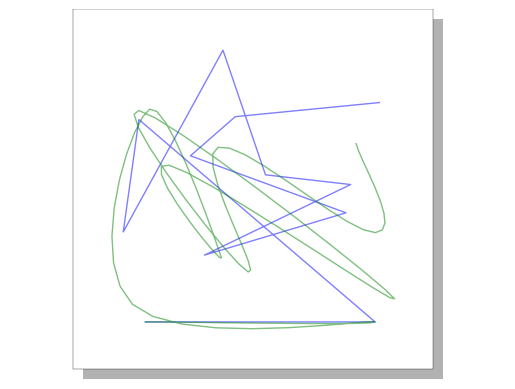

In [228]:
pts = uniform_glyph_baseline()
curve_path_aug = (
    bezmerizing.Polyline(pts) # create a Polyline object
    .augment() # duplicate first and last points
    .catmull_spline(tightness=-0.25) # generate catmull rom spline
    .to_polyline(10) # convert spline back to polyline w/10 pts per curve
)

vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale("1mm")
with vsk.pushMatrix():
    vsk.scale(80)
    vsk.stroke(1)
    vsk.polygon(pts) # comment out this line to hide original polyline!
    vsk.stroke(2)
    vsk.polygon(curve_pts)
vsk.display()

### Organic grid forms

The following example copies the grid of alien letterforms above, but uses `.augment()` and `.catmull_spline()` to convert the points to curves before drawing. The results are much more "organic":

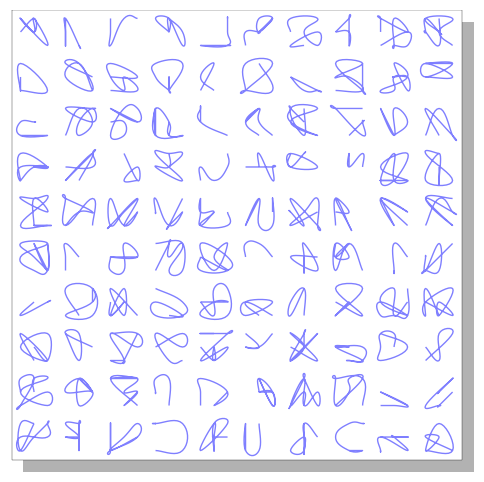

In [273]:
width = 100
height = 100
grid_size = 10

cell_size_x = width / grid_size
cell_size_y = height / grid_size

scale_val = (width / grid_size) * 0.6

vsk = vsketch.Vsketch()
vsk.size(f"{width}mm", f"{height}mm")
vsk.scale("1mm")

for i in range(grid_size):
    for j in range(grid_size):
        glyph = grid_glyph()
        smooth = (
            bezmerizing.Polyline(glyph)
            .augment()
            .catmull_spline(tightness=-0.5)
            .to_polyline(10)
        )
        with vsk.pushMatrix():
            vsk.translate(i * cell_size_x, j * cell_size_y)
            vsk.scale(scale_val)
            vsk.polygon(smooth)
vsk.display(fig_size=(6, 6))

## Scribbling in a line

Writing in certain alphabets proceeds in a linear direction across the page with connected letters; English cursive does this in particular. To simulate this, I wrote a function that generates a polyline with random points evenly spaced along a line horizontally, with the y-coordinate of each point set according to a random number selected from a normal distribution centered on zero.

In [237]:
def make_scribble(width, height, steps, stddev=0):
    pts = []
    for i in range(steps):
        x = ((width / steps) * i) + normal(0, stddev)
        y = normal(0, height)
        pts.append([x, y])
    return pts

Drawn on its own, you just get a bunch of up-and-down lines:

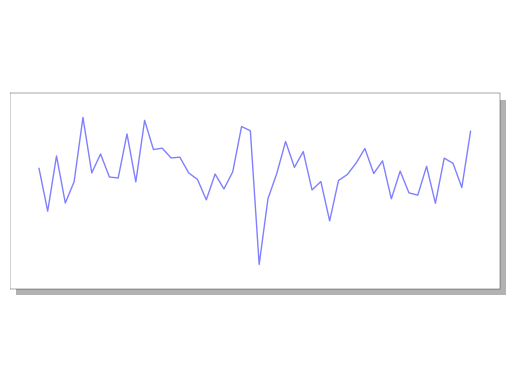

In [239]:
vsk = vsketch.Vsketch()
vsk.size("200mm", "80mm")
vsk.scale("1mm")
pts = make_scribble(width=180, height=10, steps=50, stddev=0)
vsk.polygon(pts)
vsk.display()

But with a Catmull-Rom spline, you get something that looks a little more handwriting-like:

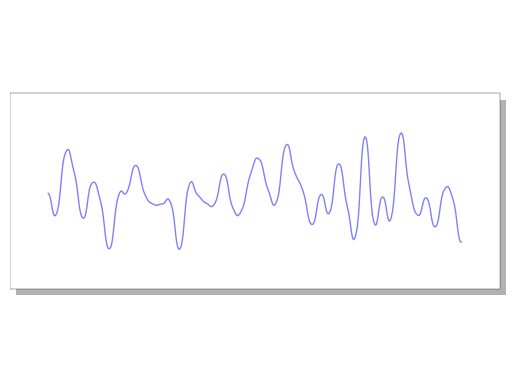

In [248]:
vsk = vsketch.Vsketch()
vsk.size("200mm", "80mm")
vsk.scale("1mm")
pts = make_scribble(width=180, height=10, steps=50, stddev=0)
curve_pts = bezmerizing.Polyline(pts).catmull_spline(tightness=-0.5).to_polyline(10)
vsk.polygon(curve_pts)
vsk.display()

The function also has a `stddev` parameter that allows you to adjust the standard deviation of a normally-distributed random number that adjusts the spacing of each point along the x-axis. This allows for the possibility of letters looping back on themselves:

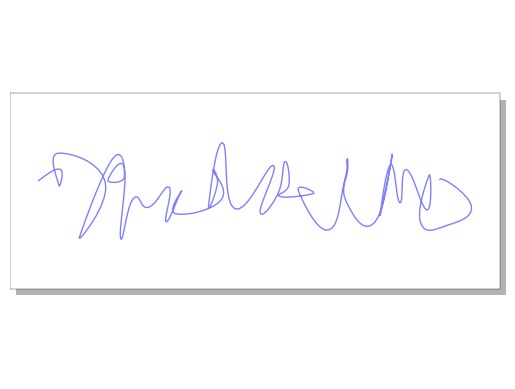

In [250]:
vsk = vsketch.Vsketch()
vsk.size("200mm", "80mm")
vsk.scale("1mm")
pts = make_scribble(width=180, height=10, steps=50, stddev=5)
curve_pts = bezmerizing.Polyline(pts).catmull_spline(tightness=-0.5).to_polyline(10)
vsk.polygon(curve_pts)
vsk.display()

The following example displays multiple "lines" of these scribbles, moving down the page, using a `for` loop, varying many parameters:

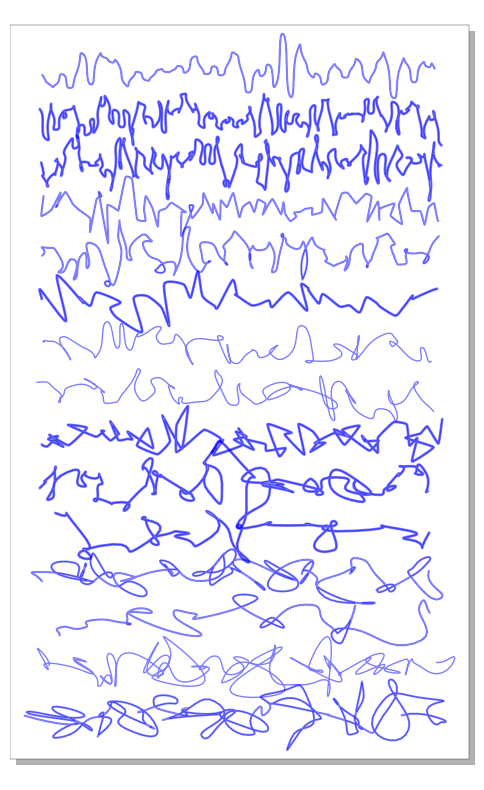

In [276]:
vsk = vsketch.Vsketch()
vsk.size("200mm", "320mm")
vsk.scale("1mm")
for i in range(15):
    pts = make_scribble(width=180, height=5, steps=int(uniform(25, 100)), stddev=i * 0.5)
    curve_pts = bezmerizing.Polyline(pts).catmull_spline(tightness=uniform(-4, 1)).to_polyline(10)
    vsk.strokeWeight(choice([1, 2, 3]))
    with vsk.pushMatrix():
        vsk.translate(0, i * 20)
        vsk.polygon(curve_pts)
vsk.display(fig_size=(6, 10))

> Exercise: Introduce randomly-placed crosses (like the cross in `t`) and dots (as in `i`).

## Conclusion

This notebook has covered some basic concepts and techniques for producing generative asemic letterforms, alongside techniques for laying those letterforms out on the page. This has been a somewhat opinionated overview, and it is nowhere close to being comprehensive! Nevertheless I hope it provides a good starting point.